## Does Stance Improve Prediction in the Toxic Challenge?

### PART 1 - IMPORT MODULES AND DATA

In [20]:
## Import modules

## Standard modules
import numpy as np 
import pandas as pd
import re
import sys
import string

## NLTK modules
from nltk.tokenize import TweetTokenizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

## Scikit learn modules
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

## Plotting
import matplotlib.pyplot as plt

In [2]:
## Import test data, train data, and stance variables
## NOTE: John Speed only imported 1000 rows because he wasn't able to generate stance variables for 1000 comments
## given the limitations of RANDLex.
train = pd.read_csv(r"C:\Users\jmeyers\Desktop\NLP and Features\data\toxic_train.csv", nrows=1000) 
##test  = pd.read_csv(r"C:\Users\jmeyers\Desktop\NLP and Features\data\toxic_test.csv",  nrows=50000)_csv
stance = pd.read_csv(r"C:\Users\jmeyers\Desktop\NLP and Features\data\stance_extraction_1000comments.csv")

In [3]:
## Merge training set and stance variables
## NOTE: One comment lost in merging (n=999). If I had more time, I would figure out what the problem is. Given that this is
## this project is for a text analysis class, finding this problem is not sufficiently important
## to justify the time fixing it.
train = pd.merge(train, stance, on='id')

### PART 2 - CLEAN DATA

##### Task 1: Remove links and images

In [4]:
## Task 1: Function to remove links and images
def cleanText(text):
    toRemove = ["https*\S+", "Image:"]
    patterns = re.compile('(%s)' % '|'.join(toRemove))
    text = re.sub(patterns, "", text)
    text = re.sub('\n', ' ', text)
    return text

##### Task 2: Expand contractions

In [5]:
# from pycontractions import Contractions
## Load your favorite word2vec model
# cont = Contractions('../input/googlenewsvectorsnegative300/GoogleNews-vectors-negative300.bin')
## optional, prevents loading on first expand_texts call
# cont.load_models()
# expanded_text = train.comment_text.tolist()
# expanded_text = list(cont.expand_texts(expanded_text))

contractions_dict = {
  "ain't": "am not",
  "aren't": "are not",
  "can't": "cannot",
  "can't've": "cannot have",
  "'cause": "because",
  "could've": "could have",
  "couldn't've": "could not have",
  "couldn't": "could not",
  "didn't": "did not",
  "doesn't": "does not",
  "don't": "do not",
  "hadn't've": "had not have",
  "hadn't": "had not",
  "hasn't": "has not",
  "haven't": "have not",
  "he'd've": "he would have",
  "he'd": "he would",
  "he'll've": "he will have",
  "he'll": "he will",
  "he's": "he is",
  "how'd'y": "how do you",
  "how'd": "how did",
  "how'll": "how will",
  "how's": "how is",
  "i'd've": "i would have",
  "i'd": "i would",
  "i'll've": "i will have",
  "i'll": "i will",
  "i'm": "i am",
  "i've": "i have",
  "isn't": "is not",
  "it'd've": "it would have",
  "it'd": "it had",
  "it'll've": "it will have",
  "it'll": "it will",
  "it's": "it is",
  "let's": "let us",
  "ma'am": "madam",
  "mayn't": "may not",
  "might've": "might have",
  "mightn't've": "might not have",
  "mightn't": "might not",
  "must've": "must have",
  "mustn't've": "must not have", 
  "mustn't": "must not",
  "needn't've": "need not have",
  "needn't": "need not",
  "o'clock": "of the clock",
  "oughtn't've": "ought not have", 
  "oughtn't": "ought not",
  "shan't've": "shall not have",
  "sha'n't": "shall not", 
  "shan't": "shall not",
  "she'd've": "she would have",
  "she'd": "she would",
  "she'll've": "she will have",
  "she'll": "she will",
  "she's": "she is",
  "should've": "should have",
  "shouldn't've": "should not have",
  "shouldn't": "should not",
  "so've": "so have",
  "so's": "so is",
  "that'd've": "that would have",
  "that'd": "that would",
  "that's": "that is",
  "there'd've": "there would have",
  "there'd": "there had",
  "there's": "there is",
  "they'd've": "they would have", 
  "they'd": "they would",
  "they'll've": "they will have",
  "they'll": "they will",
  "they're": "they are",
  "they've": "they have",
  "to've": "to have",
  "wasn't": "was not",
  "we'd've": "we would have",
  "we'd": "we had",
  "we'll've": "we will have",
  "we'll": "we will",
  "we're": "we are",
  "we've": "we have",
  "weren't": "were not",
  "what'll've": "what will have",  
  "what'll": "what will",
  "what're": "what are",
  "what's": "what is",
  "what've": "what have",
  "when's": "when is",
  "when've": "when have",
  "where'd": "where did",
  "where's": "where is",
  "where've": "where have",
  "who'll've": "who will have", 
  "who'll": "who will",
  "who's": "who is",
  "who've": "who have",
  "why's": "why is",
  "why've": "why have",
  "will've": "will have",
  "won't": "will not",
  "won't've": "will not have",
  "would've": "would have",
  "wouldn't've": "would not have", 
  "wouldn't": "would not",
  "y'all'd've": "you all would have",
  "y'all'd": "you all would",
  "y'all're": "you all are",
  "y'all've": "you all have",
  "y'all": "you all",
  "y'alls": "you alls",
  "you'd've": "you would have",
  "you'd": "you had",
  "you'll've": "you you will have",
  "you'll": "you you will",
  "you're": "you are",
  "you've": "you have"
}

contractions_re = re.compile('(%s)' % '|'.join(contractions_dict.keys()))

## Function to remove contractions
def expandContractions(text, contractions_re = contractions_re):
    def replace(match):
        return contractions_dict[match.group(0)]
    return contractions_re.sub(replace, text.lower())


##### Task 3: Implement tasks 1 and 2 on text

In [6]:
## Create copy of original training dataset and apply contractions and cleaning functions
train_cleaned = train.copy()
train_cleaned['comment_text'] = train_cleaned['comment_text'].apply(expandContractions).apply(cleanText)


##### Task 4: Create tokenizer and punctuation remover

In [7]:
porter = PorterStemmer() ## Instantiate porter stemmer

## Create Porter Stemmer tokenizer that also removes punctuation
def porterTokenizer(text):
    tknz = TweetTokenizer()
    words = []    
    for word in tknz.tokenize(text):
        # remove punctuation
        if (word not in string.punctuation and
                word not in ['...', '…']):
            words.append(word)
    return [porter.stem(w) for w in words]


##### Task 5: Create training and test datasets

In [8]:
## NO STANCE VARIABLE DATASET
## NOTE: THIS CODE MIGHT KILL YOUR KERNEL IF YOU DO NOT REDUCE THE SIZE OF THE DATASET IN THE IMPORT STAGE.

## Set X [predictors/independent variables] and y [target variables/dependent variables]
X = train_cleaned['comment_text'].values
y = train_cleaned.iloc[:, 2:3].values

## Split training and test set
X_train, X_test, y_train_nostance, y_test_nostance = train_test_split(X, y,
                                                                      test_size = 0.1,
                                                                      random_state = 5)

sys.setrecursionlimit(50000) ## the stemmer hit the default recursion limit 1000

## Create Term Frequency-Inverse Document Frequency Matrix
tfidf = TfidfVectorizer(tokenizer = porterTokenizer, stop_words='english', ngram_range=(1,2))
X_train = tfidf.fit_transform(X_train)
X_test = tfidf.transform(X_test)

## Perform singular value decomposition on TF-IDF matrix
tSVD = TruncatedSVD(n_components=100, random_state=1)
X_train_nostance = tSVD.fit_transform(X_train)
X_test_nostance = tSVD.transform(X_test)


In [10]:
## STANCE VARIABLE DATASET
## NOTE: THIS CODE MIGHT KILL YOUR KERNEL IF YOU DO NOT REDUCE THE SIZE OF THE DATASET IN THE IMPORT STAGE.

## Set X [predictors/independent variables] and y [target variables/dependent variables]
## Select both text column and stance variables
X = train_cleaned.iloc[:, np.r_[1, 3:13]].values
y = train_cleaned.iloc[:, 2:3].values

## Split training and test set
X_train, X_test, y_train_stance, y_test_stance = train_test_split(X, y,
                                                   test_size = 0.1,
                                                   random_state = 1)

sys.setrecursionlimit(50000) ## the stemmer hit the default recursion limit 1000

## Create Term Frequency-Inverse Document Frequency Matrix
tfidf = TfidfVectorizer(tokenizer = porterTokenizer, stop_words='english', ngram_range=(1,2))
X_train_tfidf = tfidf.fit_transform(X_train[:,0])
X_test_tfidf = tfidf.transform(X_test[:,0])

## Perform singular value decomposition on TF-IDF matrix
tSVD = TruncatedSVD(n_components=100, random_state=1)
X_train_svd = tSVD.fit_transform(X_train_tfidf)
X_test_svd = tSVD.transform(X_test_tfidf)

## concatenate SVD with stance
X_train_stance = np.concatenate((X_train_svd, X_train[:,1:12]), axis=1)
X_test_stance  = np.concatenate((X_test_svd,  X_test[:,1:12]),  axis=1)


### RUN MODELS WITH AND WITHOUT STANCE FEATURES - VISUALIZE ROC CURVES

In [38]:
## Instantiate Gaussian Naive Bayes
nb = GaussianNB()

## Fit model on training data
## Use ravel() to flatten target variable and avoid warning messages
nb.fit(X_train_nostance, y_train_nostance.ravel())

## Predict probabilities
nb_train_preds = nb.predict_proba(X_train_nostance)
nb_test_preds = nb.predict_proba(X_test_nostance)

## Save false positive rate, true positive rate, and thresholds to create ROC curve
fpr_nostance, tpr_nostance, thresholds = roc_curve(y_test_nostance,
                                 nb_test_preds[:,1:2],
                                 pos_label=1)

## Calculate and print AUC score
nb_train_score = roc_auc_score(y_train_nostance, nb_train_preds[:,1:2])
nb_test_score = roc_auc_score(y_test_nostance, nb_test_preds[:,1:2])
print('Train ROC AUC [Naive Bayes without stance]: %0.3f)' % nb_train_score)
print('Test ROC AUC [Naive Bayes without stance]: %0.3f)' % nb_test_score)

Train ROC AUC [Naive Bayes without stance]: 0.844)
Test ROC AUC [Naive Bayes without stance]: 0.724)


In [35]:
## Instantiate Gaussian Naive Bayes
nb = GaussianNB()

## Fit model on training data
## Use ravel() to flatten target variable and avoid warning messages
nb.fit(X_train_stance, y_train_stance.ravel())

## Predict probabilities
nb_train_preds = nb.predict_proba(X_train_stance)
nb_test_preds = nb.predict_proba(X_test_stance)

## Save false positive rate, true positive rate, and thresholds to create ROC curve
fpr_stance, tpr_stance, thresholds = roc_curve(y_test_stance,
                                 nb_test_preds[:,1:2],
                                 pos_label=1)

## Calculate and print AUC score
nb_train_score = roc_auc_score(y_train_stance, nb_train_preds[:,1:2])
nb_test_score = roc_auc_score(y_test_stance, nb_test_preds[:,1:2])
print('Train ROC AUC [Naive Bayes with stance]: %0.3f)' % nb_train_score)
print('Test ROC AUC [Naive Bayes with stance]: %0.3f)' % nb_test_score)

Train ROC AUC [Naive Bayes with stance]: 0.863)
Test ROC AUC [Naive Bayes with stance]: 0.856)


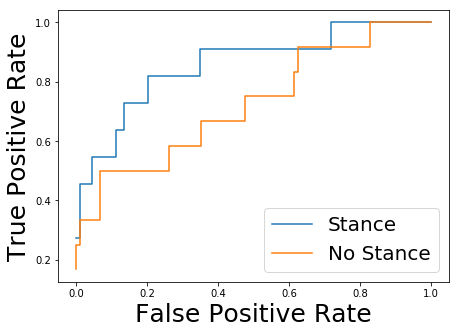

In [42]:
fig = plt.figure(figsize=(7, 5))
#plt.title('Naive Bayes', fontsize=40)
plt.plot(fpr_stance, tpr_stance, label="Stance")
plt.plot(fpr_nostance, tpr_nostance, label="No Stance")
plt.legend(loc="lower right", fontsize=20)
plt.ylabel('True Positive Rate', fontsize=25)
plt.xlabel('False Positive Rate', fontsize=25)
plt.show()

In [43]:
## Instantiate support vector machine
svm = SVC(kernel='linear', C=1, random_state=1, probability=True)

## Fit model on training data
## Use ravel() to flatten target variable and avoid warning messages
svm.fit(X_train_nostance, y_train_nostance.ravel())

## Predict probabilities
svm_train_preds = svm.predict_proba(X_train_nostance)
svm_test_preds = svm.predict_proba(X_test_nostance)

## Save false positive rate, true positive rate, and thresholds to create ROC curve
fpr_nostance, tpr_nostance, thresholds = roc_curve(y_test_nostance,
                                 svm_test_preds[:,1:2],
                                 pos_label=1)

## Calculate and print AUC score
svm_train_score = roc_auc_score(y_train_nostance, svm_train_preds[:,1:2])
svm_test_score = roc_auc_score(y_test_nostance, svm_test_preds[:,1:2])
print('Train ROC AUC [Support Vector Machine without stance]: %0.3f)' % svm_train_score)
print('Test ROC AUC [Support Vector Machine without stance]: %0.3f)' % svm_test_score)

Train ROC AUC [Support Vector Machine without stance]: 0.934)
Test ROC AUC [Support Vector Machine without stance]: 0.865)


In [44]:
## Instantiate support vector machine
svm = SVC(kernel='linear', C=1, random_state=1, probability=True)

## Fit model on training data
## Use ravel() to flatten target variable and avoid warning messages
svm.fit(X_train_stance, y_train_stance.ravel())

## Predict probabilities
svm_train_preds = svm.predict_proba(X_train_stance)
svm_test_preds = svm.predict_proba(X_test_stance)

## Save false positive rate, true positive rate, and thresholds to create ROC curve
fpr_stance, tpr_stance, thresholds = roc_curve(y_test_stance,
                                 svm_test_preds[:,1:2],
                                 pos_label=1)

## Calculate and print AUC score
svm_train_score = roc_auc_score(y_train_stance, svm_train_preds[:,1:2])
svm_test_score = roc_auc_score(y_test_stance, svm_test_preds[:,1:2])
print('Train ROC AUC [Support Vector Machine with stance]: %0.3f)' % svm_train_score)
print('Test ROC AUC [Support Vector Machine with stance]: %0.3f)' % svm_test_score)

Train ROC AUC [Support Vector Machine with stance]: 0.912)
Test ROC AUC [Support Vector Machine with stance]: 0.901)


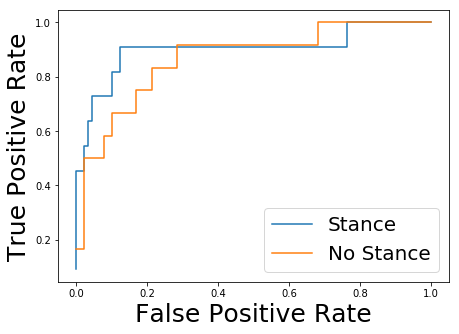

In [45]:
fig = plt.figure(figsize=(7, 5))
#plt.title('Support Vector Machine', fontsize=40)
plt.plot(fpr_stance, tpr_stance, label="Stance")
plt.plot(fpr_nostance, tpr_nostance, label="No Stance")
plt.legend(loc="lower right", fontsize=20)
plt.ylabel('True Positive Rate', fontsize=25)
plt.xlabel('False Positive Rate', fontsize=25)
plt.show()

In [46]:
## Instantiate Random Forests Classifier
rf = RandomForestClassifier(n_estimators=150, random_state = 1, n_jobs = -1)

## Fit model on training data
## Use ravel() to flatten target variable and avoid warning messages
rf.fit(X_train_nostance, y_train_nostance.ravel())

## Predict probabilities
rf_train_preds = rf.predict_proba(X_train_nostance)
rf_test_preds  = rf.predict_proba(X_test_nostance)

## Save false positive rate, true positive rate, and thresholds to create ROC curve
fpr_nostance, tpr_nostance, thresholds = roc_curve(y_test_nostance,
                                 rf_test_preds[:,1:2],
                                 pos_label=1)

## Calculate and print AUC score
rf_train_score = roc_auc_score(y_train_nostance, rf_train_preds[:,1:2])
rf_test_score = roc_auc_score(y_test_nostance, rf_test_preds[:,1:2])
print('Train ROC AUC [Random Forests without stance]: %0.3f)' % rf_train_score)
print('Test ROC AUC [Random Forests without stance]: %0.3f)'  % rf_test_score)

Train ROC AUC [Random Forests without stance]: 1.000)
Test ROC AUC [Random Forests without stance]: 0.746)


In [47]:
## Instantiate Random Forests Classifier
rf = RandomForestClassifier(n_estimators=150, random_state = 1, n_jobs = -1)

## Fit model on training data
## Use ravel() to flatten target variable and avoid warning messages
rf.fit(X_train_stance, y_train_stance.ravel())

## Predict probabilities
rf_train_preds = rf.predict_proba(X_train_stance)
rf_test_preds  = rf.predict_proba(X_test_stance)

## Save false positive rate, true positive rate, and thresholds to create ROC curve
fpr_stance, tpr_stance, thresholds = roc_curve(y_test_stance,
                                 rf_test_preds[:,1:2],
                                 pos_label=1)

## Calculate and print AUC score
rf_train_score = roc_auc_score(y_train_stance, rf_train_preds[:,1:2])
rf_test_score = roc_auc_score(y_test_stance, rf_test_preds[:,1:2])
print('Train ROC AUC [Random Forests with stance]: %0.3f)' % rf_train_score)
print('Test ROC AUC [Random Forests with stance]: %0.3f)'  % rf_test_score)

Train ROC AUC [Random Forests with stance]: 1.000)
Test ROC AUC [Random Forests with stance]: 0.887)


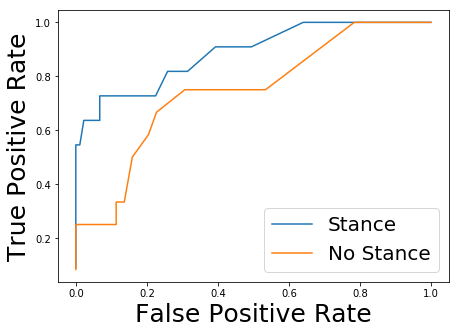

In [48]:
fig = plt.figure(figsize=(7, 5))
#plt.title('Random Forests', fontsize=40)
plt.plot(fpr_stance, tpr_stance, label="Stance")
plt.plot(fpr_nostance, tpr_nostance, label="No Stance")
plt.legend(loc="lower right", fontsize=20)
plt.ylabel('True Positive Rate', fontsize=25)
plt.xlabel('False Positive Rate', fontsize=25)
plt.show()